In [17]:
#Manejo de datos
import pandas as pd 
#Manejo de tensores
import numpy as np
#Visualizadores
import matplotlib.pyplot as plt
import seaborn as sns
#Modelos lineales 
from sklearn.linear_model import Lasso, Ridge, LinearRegression
#Modelos no lineales 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
#Estandarizador
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#Metricas de evaluacion
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#Optimizacion y validacion
from sklearn.model_selection import RandomizedSearchCV, train_test_split , KFold, cross_val_score
#Piplines
from sklearn.pipeline import Pipeline
#Transformador
from sklearn.compose import ColumnTransformer
#Herramienta estadistica para numeros aleatorios discretos y continuos
from scipy.stats import randint, uniform
#Selector de features
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
df = pd.read_csv('../data/housing_clean.csv')
df.head(4)

,longitude,latitude,housing_median_age,population,households,median_income,median_house_value,ocean_proximity,bedrooms_x_room
0,-122.23,37.88,41.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0.146591
1,-122.22,37.86,21.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0.155797
2,-122.24,37.85,52.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0.129516
3,-122.25,37.85,52.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0.184458


In [3]:
#definir que variables son caracteristicas y cual es el objetivo
X = df.drop('median_house_value', axis=1)
Y = df['median_house_value']
#Separacion de los datos en enrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=42, test_size=0.2)

#Definir las variables para los modelos lineales 
X_train_lineal = X_train[['median_income', 'ocean_proximity', 'housing_median_age', 'bedrooms_x_room']] #Variablesque mas correlacion y sentido tienen con el objetivo
X_test_lineal = X_test[['median_income', 'ocean_proximity', 'housing_median_age', 'bedrooms_x_room']]

In [4]:
#Normalizar la categorica para el modelo lineal y seleciconar la correlacionada
X_train_lineal = pd.get_dummies(X_train_lineal, columns=['ocean_proximity'], drop_first=True, dtype=int)
X_test_lineal = pd.get_dummies(X_test_lineal, columns=['ocean_proximity'], drop_first=True, dtype=int)

#Alinear por si alguno de los valores no sale en los datasets contrarios 
X_train_lineal, X_test_lineal = X_train_lineal.align(X_test_lineal, join='left', axis=1, fill_value=0)

#Eliminar las otras variables que no presentan correlacion con el objetivo 
X_train_lineal.drop(['ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'], axis=1, inplace=True)
X_test_lineal.drop(['ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'], axis=1, inplace=True)

In [5]:
#Revisar variable para entrenamientos lineales 
X_train_lineal.head(4)

,median_income,housing_median_age,bedrooms_x_room,ocean_proximity_INLAND
14196,3.2596,33.0,0.200576,0
8267,3.8125,49.0,0.232703,0
17445,4.1563,4.0,0.174486,0
14265,1.9425,36.0,0.258269,0


In [6]:
#Separar variables numericas y categoricas para el transformador 
variables_numericas = X.select_dtypes(include=[np.number]).columns
variables_categoricas = X.select_dtypes(exclude=[np.number]).columns

In [7]:
#Crear un transformador para los modelos no lineales 
transformador_nolineal = ColumnTransformer(transformers=[
    ('num', 'passthrough', variables_numericas),
    ('cat', OneHotEncoder(handle_unknown='ignore'), variables_categoricas)
])

In [8]:
#Creacion de los modelos a utilizar
#------------------------------------------ MODELOS LINEALES ------------------------------------------------------------------------
modelos_lineales = {
    'LinearRegression': LinearRegression(),
    'Lasso_model': Lasso(alpha=1.0, random_state=42),
    'Ridge_model': Ridge(alpha=1.0, random_state=42, max_iter=10000)
}

#------------------------------------------ MODELOS NO LINEALES ------------------------------------------------------------------------
modelos_no_lineales = {
    'DecisionTree': DecisionTreeRegressor(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.8, random_state=42),
    'XGBRegressor': XGBRegressor(n_estimators=400,learning_rate=0.05,max_depth=5,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.1,reg_lambda=1.0,random_state=42,),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=10, min_samples_leaf=5, random_state=42)
}

In [9]:
#Realizar funcion para el entrenamiento de los modelos lineales 
def train_linear_models(modelos, x_train, y_test, y_train, x_test):
    resultados = {}
    for n, m in modelos.items():
        pipline = Pipeline([
            ('scaler', StandardScaler()),
            ('modelo',m)
        ])

        pipline.fit(x_train, y_train)
        pred = pipline.predict(x_test)
        mse = mean_squared_error(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)

        resultados[n] = {'mse': mse, 'mae': mae, 'r2': r2}
    
    return resultados

In [10]:
#Realizar una funcion pra los modelos no lineales
def train_unlinear_models(modelos, x_train, y_test, y_train, x_test):
    resultados = {}
    for n, m in modelos.items():
        pipline = Pipeline([
            ('preprocessor', transformador_nolineal),
            ('model', m)
        ])
        
        pipline.fit(x_train, y_train)
        pred = pipline.predict(x_test)
        mse = mean_squared_error(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        
        resultados[n] = {'mse': mse, 'mae': mae, 'r2': r2}
    
    return resultados

In [39]:
resultados_lineales = train_linear_models(modelos_lineales, X_train_lineal, Y_test, Y_train, X_test_lineal)
#Revisar resultados obtenidos
for k, v in resultados_lineales.items():
    print(f'Modelo {k}')
    print(f'Resultado: {v}')
    print('-' * 100)

Modelo LinearRegression
Resultado: {'mse': 5944238962.244125, 'mae': 54395.40030450156, 'r2': 0.546382918543209}
----------------------------------------------------------------------------------------------------
Modelo Lasso_model
Resultado: {'mse': 5944134110.372988, 'mae': 54395.15335394713, 'r2': 0.5463909200048045}
----------------------------------------------------------------------------------------------------
Modelo Ridge_model
Resultado: {'mse': 5943787279.059384, 'mae': 54394.77139176775, 'r2': 0.5464173874145493}
----------------------------------------------------------------------------------------------------


In [40]:
resultados_no_lineales = train_unlinear_models(modelos_no_lineales, X_train, Y_test, Y_train, X_test)
for k, v in resultados_no_lineales.items():
    print(f'Modelo {k}')
    print(f'Resultado: {v}')
    print('-' * 100)

Modelo DecisionTree
Resultado: {'mse': 3783621185.8360333, 'mae': 40760.91422883739, 'r2': 0.7112640977998191}
----------------------------------------------------------------------------------------------------
Modelo GradientBoostingRegressor
Resultado: {'mse': 2752473407.562449, 'mae': 35231.69795315974, 'r2': 0.7899531021790324}
----------------------------------------------------------------------------------------------------
Modelo XGBRegressor
Resultado: {'mse': 2410965831.49824, 'mae': 32746.863647460938, 'r2': 0.8160142465801223}
----------------------------------------------------------------------------------------------------
Modelo RandomForestRegressor
Resultado: {'mse': 2542506488.4338493, 'mae': 32821.26393484248, 'r2': 0.8059761089360877}
----------------------------------------------------------------------------------------------------


Podemos mirar como modelos como XGBRegressor y RandomForestRegressor son los que mejor performance tienen por lo que vamos a tunearlos para poder sacar los mejores resultados posibles

In [11]:
#Modelo base XGBRegressor
xg_model = Pipeline([('preprocesador_xg', transformador_nolineal),('model_xg', XGBRegressor(random_state=42, objective='reg:squarederror'))])
#Modelo base RandomForestRegressor
rf_model = Pipeline([('preprocesador_rf', transformador_nolineal),('model_rf',RandomForestRegressor(random_state=42))])

In [12]:
#Plantilla para xg_model
plantilla_xg = {
    'model_xg__n_estimators': randint(100, 600), #Numero de arboles
    'model_xg__max_depth': randint(3, 10), #Profundidad de los arboles
    'model_xg__learning_rate': uniform(0.01, 0.2), #Tasa de aprendizaje gd
    'model_xg__subsample': uniform(0.6, 0.4), #Muestreo de los datos
    'model_xg__colsample_bytree': uniform(0.6, 0.4), #Muestreo de columnas
    'model_xg__min_child_weight': randint(1, 8), #Peso minimo por hoja
    'model_xg__reg_alpha': uniform(0, 0.5), #Regularizacion l1
    'model_xg__reg_lambda': uniform(0.5, 2.0)#Regularizacion l2
}

#Plantilla para Randomforest
plantilla_rf = {
    'model_rf__n_estimators': randint(100, 500), #Cantidad de arboles
    'model_rf__max_depth': randint(10, 20), #Profundidad de los arboles
    'model_rf__min_samples_leaf': randint(1, 10), #Cantidad de nodos hoja
    'model_rf__min_samples_split': randint(2, 15) #Cantidad de diviciones
}

In [13]:
#Crear los optimizadores
#Para XG
xg_search = RandomizedSearchCV(
    estimator=xg_model,
    param_distributions=plantilla_xg,
    n_iter=40,
    scoring='r2',
    cv=5,
    random_state=42,
    verbose=1
)

#Para RandomForest
rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=plantilla_rf,
    n_iter=30,
    scoring='r2',
    cv=5,
    random_state=42,
    verbose=1
)

In [23]:
#Ajuste y busqueda de xg
xg_search.fit(X_train, Y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model_xg__colsample_bytree': <scipy.stats....x7f81b4e77340>, 'model_xg__learning_rate': <scipy.stats....x7f81b4e76890>, 'model_xg__max_depth': <scipy.stats....x7f81b4ce3010>, 'model_xg__min_child_weight': <scipy.stats....x7f81b4e76fe0>, ...}"
,n_iter,40
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [28]:
print(f'Mejores parametros para el modelo: \n {xg_search.best_params_}')
print(f'Mejor resultado {xg_search.best_score_}')

Mejores parametros para el modelo: 
 {'model_xg__colsample_bytree': np.float64(0.8118602313424026), 'model_xg__learning_rate': np.float64(0.05837045818009034), 'model_xg__max_depth': 8, 'model_xg__min_child_weight': 4, 'model_xg__n_estimators': 552, 'model_xg__reg_alpha': np.float64(0.4502090285816652), 'model_xg__reg_lambda': np.float64(1.7662029145465359), 'model_xg__subsample': np.float64(0.7356119164194803)}
Mejor resultado 0.8417968590791987


In [26]:
#Ajuste y bsuqeuda con el modleo rf
rf_search.fit(X_train, Y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model_rf__max_depth': <scipy.stats....x7f81b4e76bf0>, 'model_rf__min_samples_leaf': <scipy.stats....x7f81affbc760>, 'model_rf__min_samples_split': <scipy.stats....x7f81affbcbb0>, 'model_rf__n_estimators': <scipy.stats....x7f81b4e726b0>}"
,n_iter,30
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [30]:
print(f'Mejores parametros para el modelo:\n {rf_search.best_params_}')
print(f'Mejor score {rf_search.best_score_}')

Mejores parametros para el modelo:
 {'model_rf__max_depth': 17, 'model_rf__min_samples_leaf': 3, 'model_rf__min_samples_split': 2, 'model_rf__n_estimators': 491}
Mejor score 0.8130104122674922


In [75]:
#Crear el modelo con el mejor performance en la busqeuda de parametros
xg_model = Pipeline([('preprocesador', transformador_nolineal),('model', XGBRegressor(n_estimators=552,learning_rate=0.0584,max_depth=8,subsample=0.7,colsample_bytree=0.8,reg_alpha=0.4,reg_lambda=1.7,random_state=42,))])

In [76]:
#Metricas para el modelo mejorado
xg_model.fit(X_train, Y_train)
pred = xg_model.predict(X_test)
mse, mae, r2 = mean_squared_error(Y_test, pred), mean_absolute_error(Y_test, pred), r2_score(Y_test, pred)
print(f'MSE {mse} | MAE {mae} | R2 {r2}')

MSE 2171064009.380816 | MAE 30286.75951959181 | R2 0.8343216472543356


In [77]:
#Realizar validación cruzada para evaluar el modelo 
flods = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xg_model, X, Y, cv=flods, scoring='r2', verbose=2)

[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   0.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished


In [78]:
#Revisar loss resutlados de la validacion cruzada
print(f'Resultados: {scores} \nPromedio de resultados {np.mean(scores)}')

Resultados: [0.83308671 0.85121714 0.84310032 0.86138494 0.83858046] 
Promedio de resultados 0.8454739154789859


/tmp/ipykernel_58481/3328285714.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(select_k, ax=axs[0], x='Scores', y='Features',palette='pastel')
/tmp/ipykernel_58481/3328285714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(feat_impt, ax=axs[1], x='Importances', y='Features', palette='viridis')


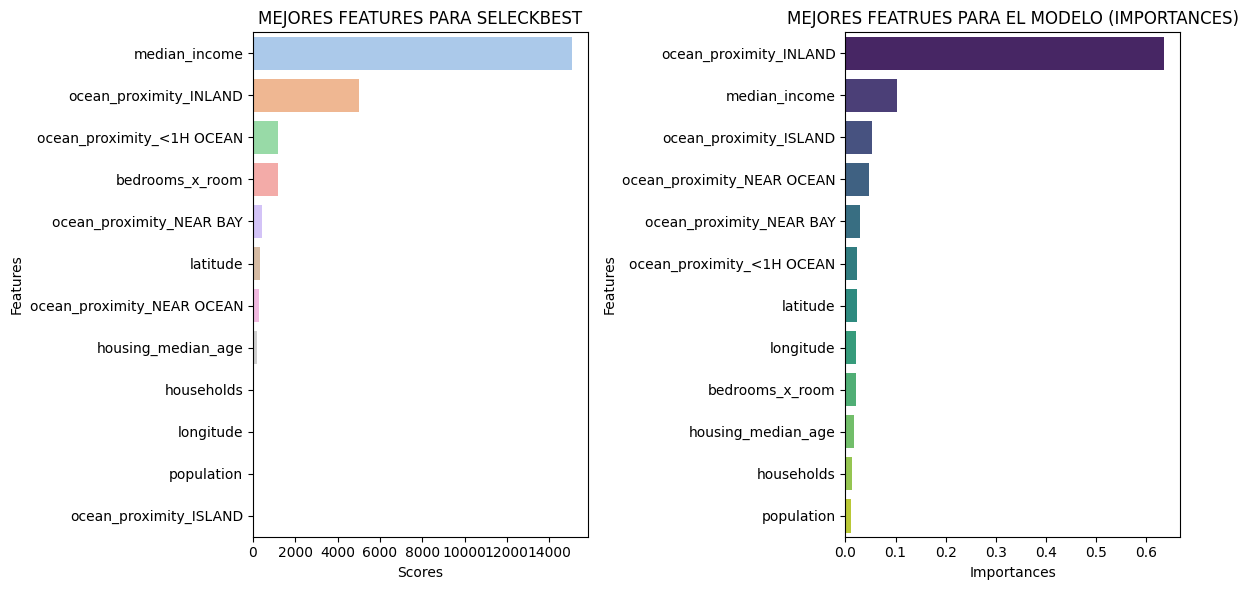

In [68]:
#SELECCIONAR LOS FEATURES MAS IMPORTANTES

#Feature importances
x_train_optim = pd.get_dummies(X_train,  dtype=int)

features = x_train_optim.columns
importances = xg_model.named_steps['model'].feature_importances_

#SelecKbest
kbest = SelectKBest(score_func=f_regression, k=3)
kbest.fit(x_train_optim, Y_train)
scores = kbest.scores_

#Dataframe de los mejores features
select_k = pd.DataFrame({'Features': features, 'Scores': scores}).sort_values(by='Scores', ascending=False)
feat_impt = pd.DataFrame({'Features': features, 'Importances': importances}).sort_values(by='Importances', ascending=False)

#Visualización
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(select_k, ax=axs[0], x='Scores', y='Features',palette='pastel')
axs[0].set_title('MEJORES FEATURES PARA SELECKBEST')

sns.barplot(feat_impt, ax=axs[1], x='Importances', y='Features', palette='viridis')
axs[1].set_title('MEJORES FEATRUES PARA EL MODELO (IMPORTANCES)')

plt.tight_layout()

# Probando con los features recomendados

In [69]:
xg_model =  XGBRegressor(n_estimators=552,learning_rate=0.0584,max_depth=8,subsample=0.7,colsample_bytree=0.8,reg_alpha=0.4,reg_lambda=1.7,random_state=42,)

In [70]:
features

Index(['longitude', 'latitude', 'housing_median_age', 'population',
       'households', 'median_income', 'bedrooms_x_room',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [71]:
x_train_optim = x_train_optim[['ocean_proximity_INLAND', 'median_income', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN', 'ocean_proximity_NEAR BAY', 'latitude']]
x_test_optim = pd.get_dummies(X_test, dtype=int)
c = x_train_optim.columns
X_test_optim = x_test_optim[c]

In [72]:
xg_model.fit(x_train_optim, Y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [73]:
#Metricas para el modelo mejorado
pred = xg_model.predict(X_test_optim)
mse, mae, r2 = mean_squared_error(Y_test, pred), mean_absolute_error(Y_test, pred), r2_score(Y_test, pred)
print(f'MSE {mse} | MAE {mae} | R2 {r2}')

MSE 4304846391.02576 | MAE 44195.66884406038 | R2 0.6714883320774703


Podemos darnos cuenta que realmente si la informacion por si sola parece que hubieran variables que no aportaran información vemos que es relevante ya qeu baja el performance del modelo probando menos variables por lo que optamos por usarlas todas